In [8]:
# Testing to extract the true values of the group of galaxies that are associated to the test:


path_parent = "/pool001/vianajr/cluster_ages_1/results/many_case/many_case_5im_remextremes_no_augment_no_blackout_inner_normby_five-images/R_0/model_0/"

In [9]:
import json
from pathlib import Path
import numpy as np

# ---- custom metric ----
def custom_median_absolute_error_np(dnrm_y_pred, dnrm_y_true):
    abs_diff = np.abs(np.array(dnrm_y_true) - np.array(dnrm_y_pred))
    return 1.49 * np.median(abs_diff)

# ---- inputs ----
file_name = "predictions_and_errors.json"

groups = {
    "Group 2": ["NGC_3351", "NGC_628C", "NGC_3627", "NGC_2835"],
    "Group 3": ["NGC_1512", "NGC_1566", "NGC_7496", "NGC_1433", "NGC_1365"],
}

# ---- load ----
data = json.loads(Path(path_parent, file_name).read_text())

tr = data.get("tr") or data.get("train") or []
ts = data.get("ts") or data.get("test") or []

all_y_true_ts = [float(r["y_true"]) for r in ts if "y_true" in r]
all_y_true_tr = [float(r["y_true"]) for r in tr if "y_true" in r]

guessed_mean_tr = float(np.mean(all_y_true_tr))

# ---- filters ----
g2_ids = set(groups["Group 2"])
g3_ids = set(groups["Group 3"])

y_ts_g2 = [float(r["y_true"]) for r in ts if r.get("galaxy_id") in g2_ids]
y_ts_g3 = [float(r["y_true"]) for r in ts if r.get("galaxy_id") in g3_ids]

# ---- apply custom error ----
results = {
    "guessed_mean_all_ts": guessed_mean_ts,
    "guessed_mean_all_tr": guessed_mean_tr,
    "custom_error_all_ts_vs_tr": custom_median_absolute_error_np(
        [guessed_mean_tr] * len(all_y_true_ts), all_y_true_ts
    ),
    "Group 2": {
        "n": len(y_ts_g2),
        "custom_error_vs_tr_mean": custom_median_absolute_error_np(
            [guessed_mean_tr] * len(y_ts_g2), y_ts_g2
        ),
    },
    "Group 3": {
        "n": len(y_ts_g3),
        "custom_error_vs_tr_mean": custom_median_absolute_error_np(
            [guessed_mean_tr] * len(y_ts_g3), y_ts_g3
        ),
    },
}

# ---- print summary ----
print(f"guessed_mean_ts: {results['guessed_mean_all_ts']:.4f}")
print(f"guessed_mean_tr: {results['guessed_mean_all_tr']:.4f}")
print(f"custom error (ALL ts vs tr_mean): {results['custom_error_all_ts_vs_tr']:.4f}")
print()
print(f"Group 2 -> n={results['Group 2']['n']}, custom_error_vs_tr_mean={results['Group 2']['custom_error_vs_tr_mean']:.4f}")
print(f"Group 3 -> n={results['Group 3']['n']}, custom_error_vs_tr_mean={results['Group 3']['custom_error_vs_tr_mean']:.4f}")


guessed_mean_ts: 7.3660
guessed_mean_tr: 7.3152
custom error (ALL ts vs tr_mean): 1.2200

Group 2 -> n=352, custom_error_vs_tr_mean=1.2489
Group 3 -> n=414, custom_error_vs_tr_mean=1.2200


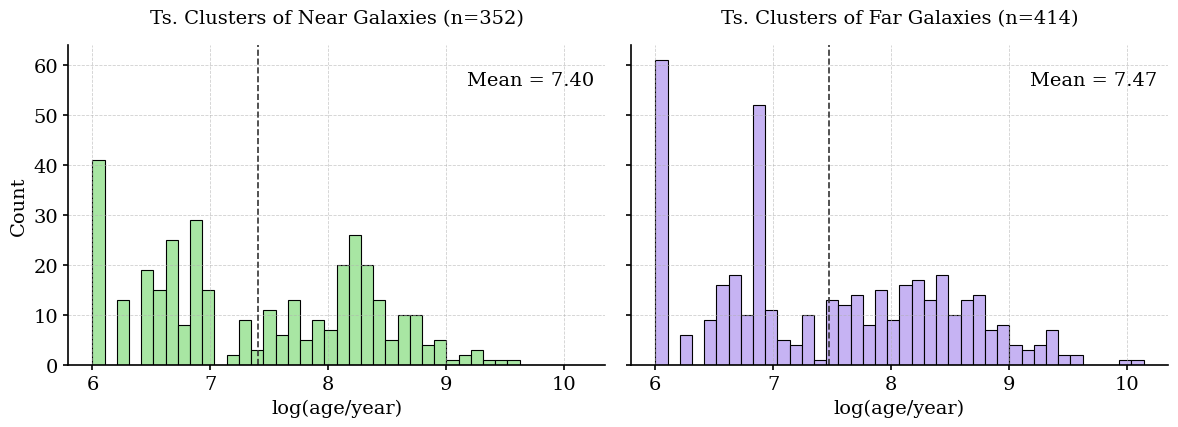

Saved: plots_storage/hist_y_true_ts_groups.svg
Saved: plots_storage/hist_y_true_ts_groups.pdf


In [24]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# -----------------------------
# Journal style
# -----------------------------
plt.rcParams.update({
    # Embed TrueType fonts for vector outputs
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    # Typography
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "font.size": 14,
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    # Aesthetics
    "axes.linewidth": 1.2,
    "axes.titlepad": 14,  # raise titles a bit
})

# -----------------------------
# Colors (pastel)
# -----------------------------
COLOR_G2 = "#A8E6A3"  # pastel green
COLOR_G3 = "#C6B3F3"  # pastel purple

# Output dir
out_dir = Path("plots_storage")
out_dir.mkdir(parents=True, exist_ok=True)

# -----------------------------
# Histograms of ts y_true by group
# -----------------------------
combined_vals = np.array(y_ts_g2 + y_ts_g3, dtype=float)
if combined_vals.size == 0:
    print("No ts y_true values found for either group; skipping histograms.")
else:
    nbins = 40
    vmin, vmax = combined_vals.min(), combined_vals.max()
    if vmin == vmax:  # avoid zero-width range
        vmin -= 0.5
        vmax += 0.5
    bin_edges = np.linspace(vmin, vmax, nbins + 1)  # shared bins

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharey=True)

    def format_axis(ax):
        ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)
        ax.tick_params(axis='both', which='both', width=1.2)
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)

    # Means
    mean_g2 = float(np.mean(y_ts_g2)) if len(y_ts_g2) else None
    mean_g3 = float(np.mean(y_ts_g3)) if len(y_ts_g3) else None

    # Group 2 (Near)
    axes[0].hist(y_ts_g2, bins=bin_edges, facecolor=COLOR_G2,
                 edgecolor='black', linewidth=0.8)
    axes[0].set_title(f"Ts. Clusters of Near Galaxies (n={len(y_ts_g2)})", pad=16)
    axes[0].set_xlabel("log(age/year)")
    axes[0].set_ylabel("Count")
    if mean_g2 is not None:
        axes[0].axvline(mean_g2, color='0.2', linestyle='--', linewidth=1.2)
        axes[0].text(0.98, 0.92, f"Mean = {mean_g2:.2f}",
                     transform=axes[0].transAxes, ha='right', va='top')
    format_axis(axes[0])

    # Group 3 (Far)
    axes[1].hist(y_ts_g3, bins=bin_edges, facecolor=COLOR_G3,
                 edgecolor='black', linewidth=0.8)
    axes[1].set_title(f"Ts. Clusters of Far Galaxies (n={len(y_ts_g3)})", pad=16)
    axes[1].set_xlabel("log(age/year)")
    if mean_g3 is not None:
        axes[1].axvline(mean_g3, color='0.2', linestyle='--', linewidth=1.2)
        axes[1].text(0.98, 0.92, f"Mean = {mean_g3:.2f}",
                     transform=axes[1].transAxes, ha='right', va='top')
    format_axis(axes[1])

    # Consistent x-limits with padding
    pad = 0.05 * (vmax - vmin)
    xlo, xhi = vmin - pad, vmax + pad
    axes[0].set_xlim(xlo, xhi)
    axes[1].set_xlim(xlo, xhi)

    plt.tight_layout()

    out_svg = out_dir / "hist_y_true_ts_groups.svg"
    out_pdf = out_dir / "hist_y_true_ts_groups.pdf"
    plt.savefig(out_svg, bbox_inches='tight', pad_inches=0.2)
    plt.savefig(out_pdf, bbox_inches='tight', pad_inches=0.2)
    plt.show()
    print(f"Saved: {out_svg}")
    print(f"Saved: {out_pdf}")
